<a href="https://colab.research.google.com/github/Ninadrmore1999/ML-projects-/blob/main/Xotica_Restraurant_footfall_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imagine you are a Data Scientist at a food chain ‘Xotica’!

Your manager has asked you to forecast the number of visitors for upcoming 39 days (almost 6 weeks) using the number of visitors recorded within the past 1-1.5 years.


Reading the data

In [ ]:
!gdown 1Um8gdIjpEx7Iv-VUoBpmGCS80ck_x7AO

Downloading...
From: https://drive.google.com/uc?id=1Um8gdIjpEx7Iv-VUoBpmGCS80ck_x7AO
To: /content/rest_vis.csv
100% 13.1k/13.1k [00:00<00:00, 28.4MB/s]


In [ ]:
df = pd.read_csv('/content/rest_vis.csv')
df.head()

,date,weekday,holiday,total
0,1/1/2016,Friday,1,296.0
1,1/2/2016,Saturday,0,191.0
2,1/3/2016,Sunday,0,202.0
3,1/4/2016,Monday,0,105.0
4,1/5/2016,Tuesday,0,98.0


In [ ]:
df.shape

(517, 4)


The provided dataset has features `‘Date’, ‘holiday’, 'weekday' and 'total`(total no. of visitors).

The data consists of number of **daily** visitors to the restaurant located in the United States, subject to American holidays.

The data set contains 517 days: 478 days of restaurant's data and 39 days of data which have `Nan` in `total`.

Let's find out the number of rows having values 'Nan' in dataset.

In [ ]:
df.isna().sum()

date        0
weekday     0
holiday     0
total      39
dtype: int64

Here let's keep a copy of the original data so that in future, even after modifications on the data we won't have to read the csv again and again.

In [ ]:
df1 = df.copy()

Let's drop all the rows which have `Nan`.

In [ ]:
df.dropna(inplace = True)

Set the `date` column as index after converting it to datetime format.

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace = True)
df.head(5)

,weekday,holiday,total
date,,,
2016-01-01,Friday,1,296.0
2016-01-02,Saturday,0,191.0
2016-01-03,Sunday,0,202.0
2016-01-04,Monday,0,105.0
2016-01-05,Tuesday,0,98.0


**NOTE:-**
- Here you can see, that the target variable of the time series is the ```total``` column.
- In our last business case, we saw only date and the target variable.
- However, there are other columns: ```holiday, weekday```.

<br>





#### Plot the source data.

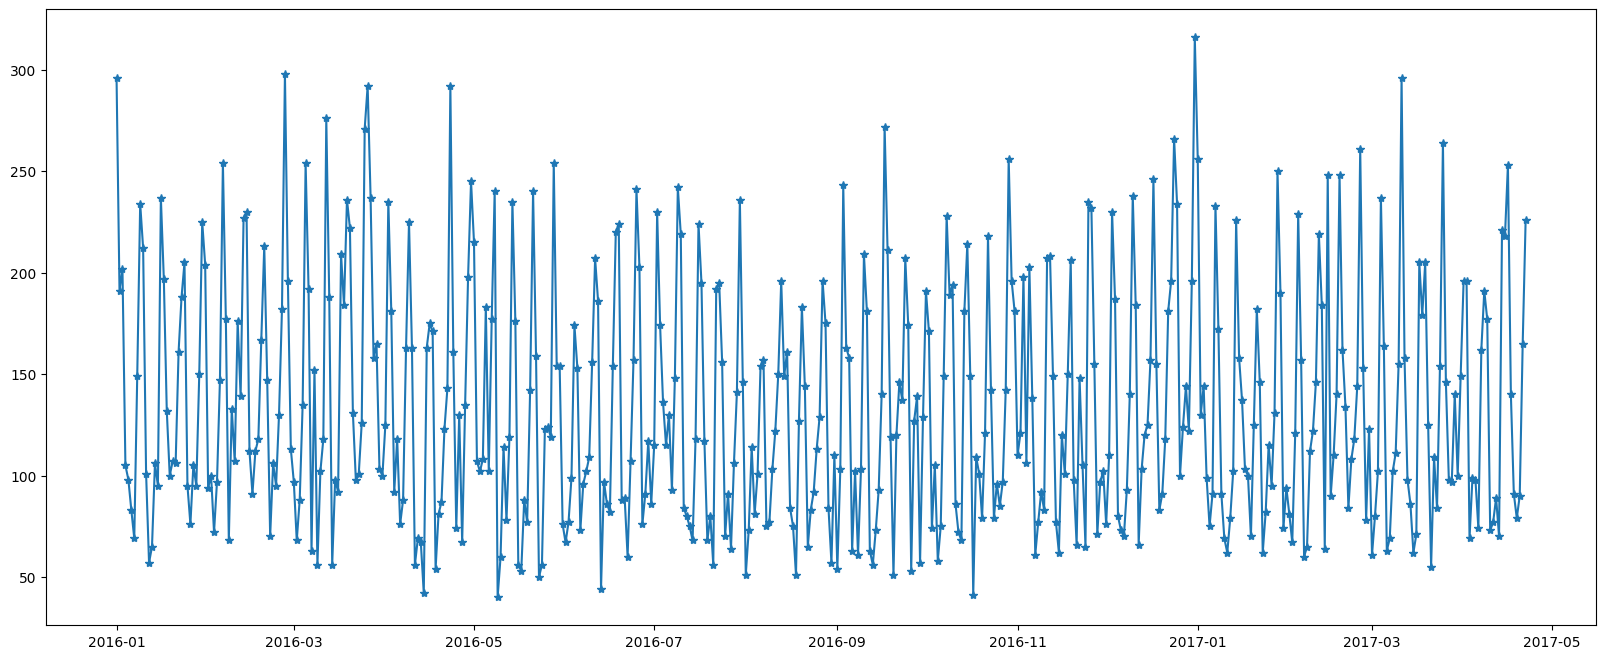

In [ ]:
# Lets take a look at our time series plot
plt.plot(df.index, df['total'], '-*')
plt.show()

> **INTERACTION**
> - Can you guess which days of the week can the peaks in the data represent?
> - Ans: weekends

In the above plot, we can see the peaks but we can't map those peaks to any particular days. Therefore let's try to decrease the number of days to plot, so that we get more insights.

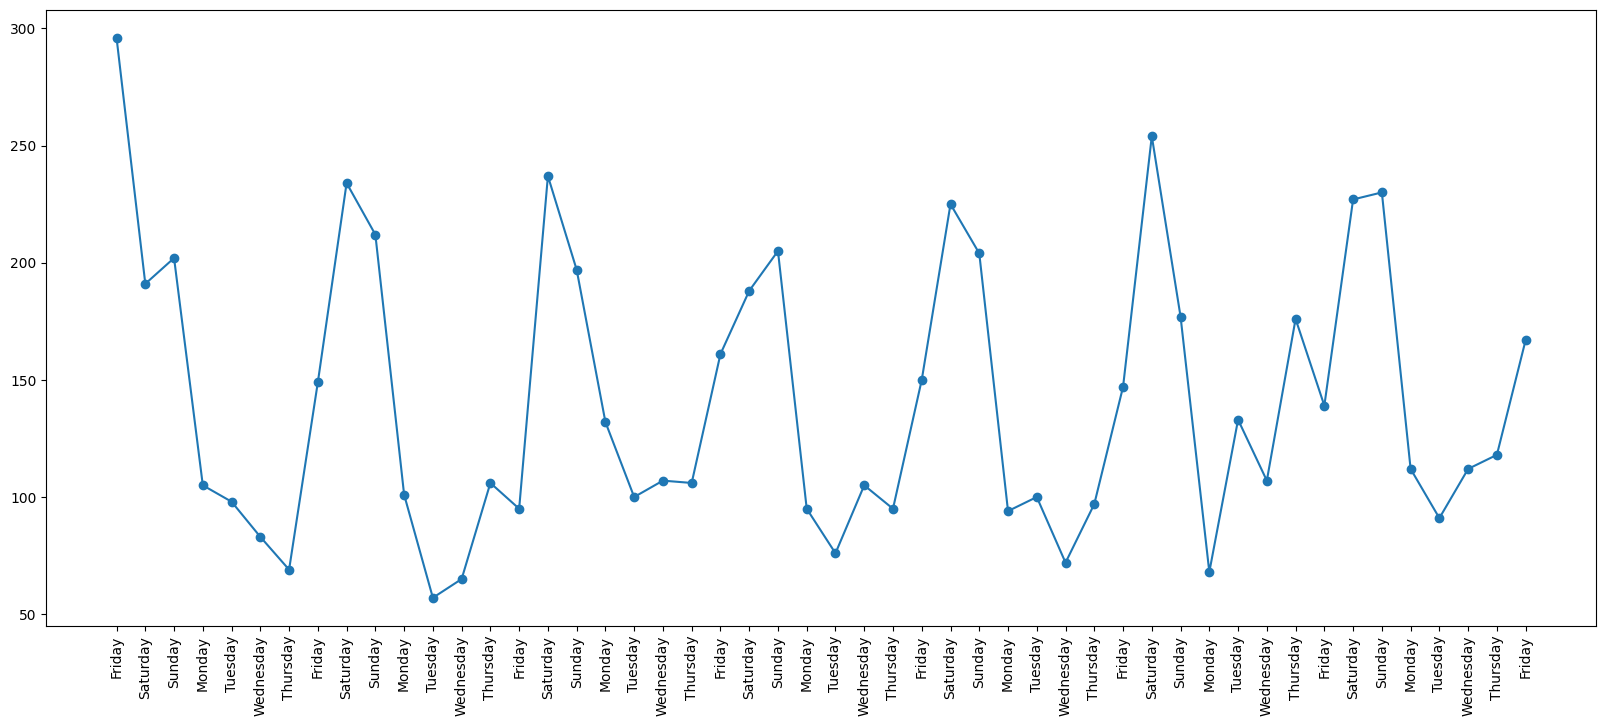

In [ ]:
plt.plot(range(50),df['total'][:50], '-o')
plt.xticks(range(0,50), df['weekday'][:50],rotation = 90)
plt.show()

It is easily observable that the peaks in the number of visitors is around Saturday and Sunday.

#### Plot the data with holidays.

We also have the data about `holidays`, therefore let's visualize it to observe any relationship between holidays and number of people visiting if it exists.

In [ ]:
df['holiday'].value_counts()

0    446
1     32
Name: holiday, dtype: int64

feature `holiday` is representing whether there is holiday (1) on the day or not(0).

Plot of data with `holiday`. Lets use a red line to indicate that the given day is a holiday.

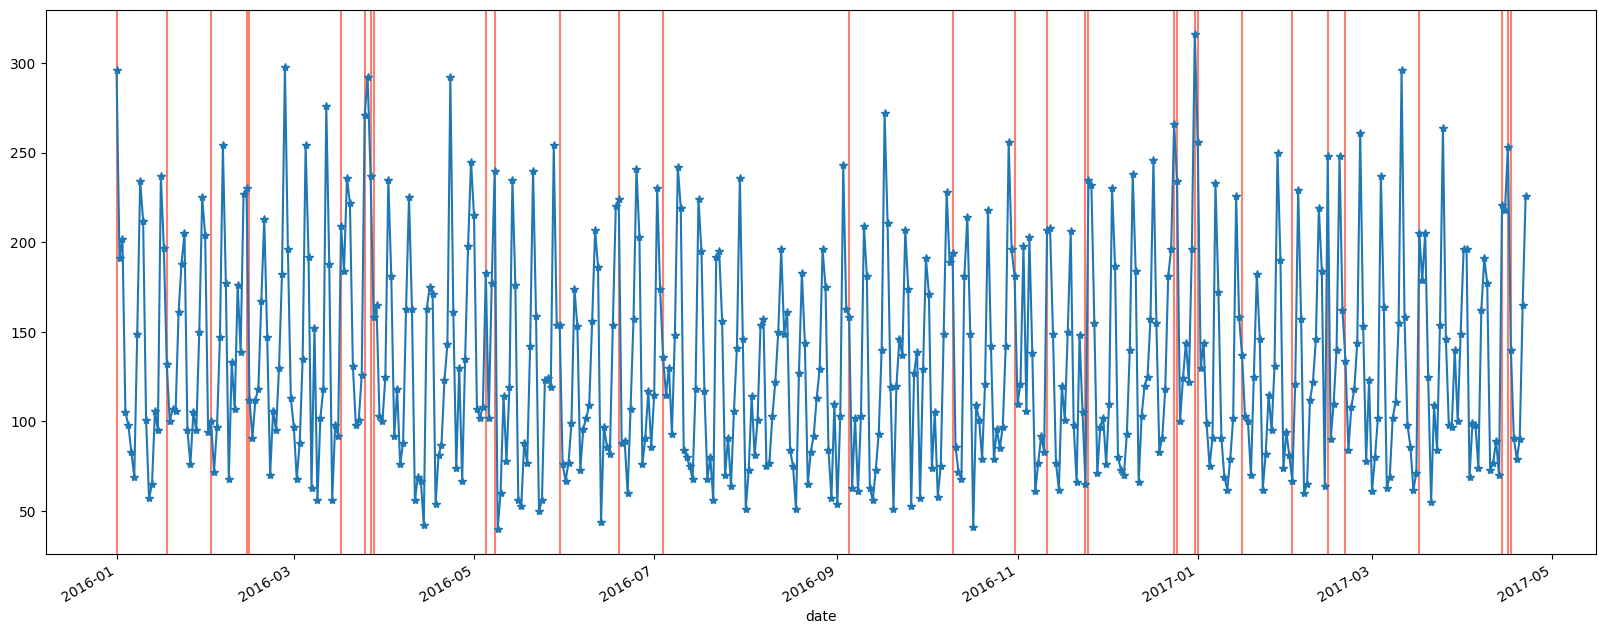

In [ ]:
# Lets take a look at our time series plot
holidays = df.loc[df.holiday==1].index
for hday in holidays:
    plt.axvline(x=hday, color='#FA8072')
df.total.plot(style='-*')
plt.show()

**Notice:-**
- We can see that holidays generally see a **peak** in foot falls.

**Now let's try to decompose the time series to see if it follows any pattern**

<Figure size 2000x800 with 0 Axes>

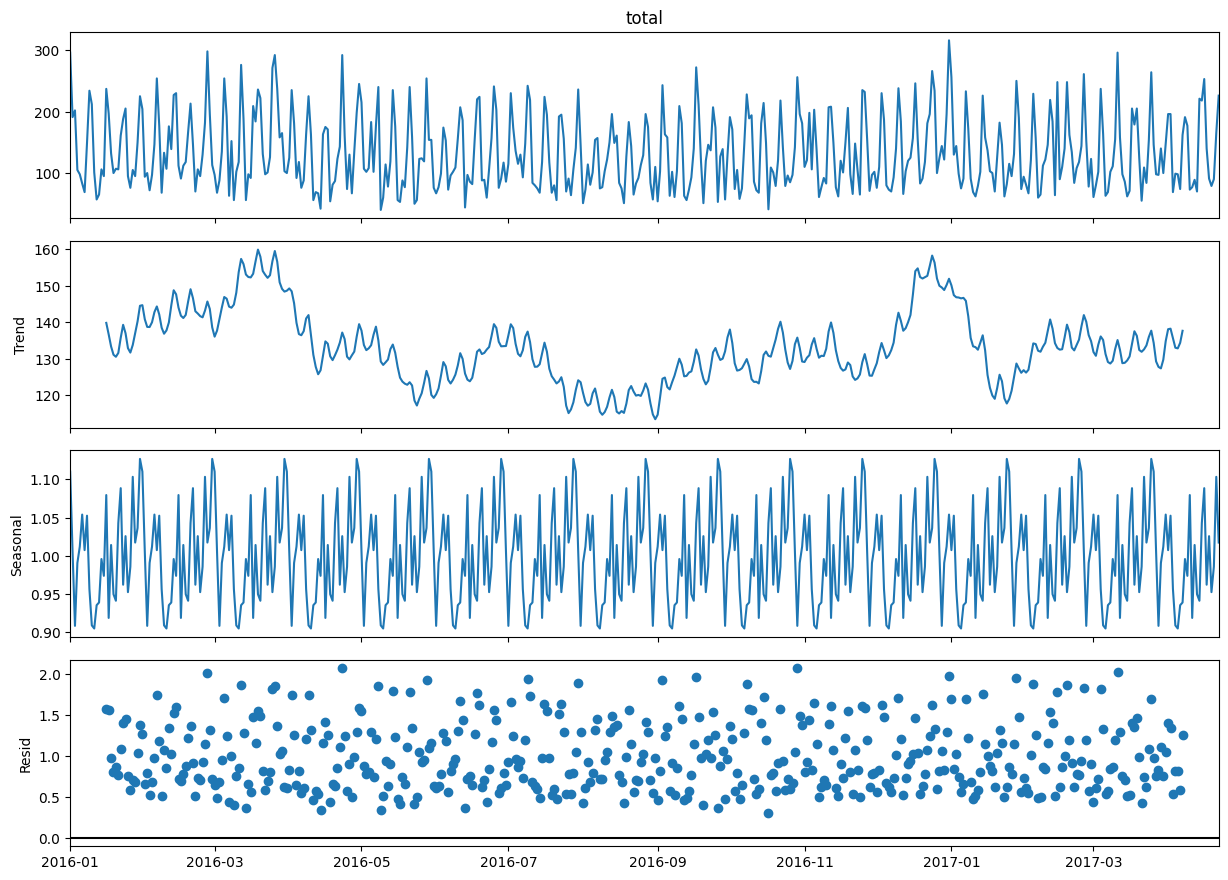

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['total'], model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(12, 9)
fig.show()

* From the above decomposition, it's visible that the data consists of seasonality and the trend is increasing and decreasing which is understandable as the number of visitors will increase during the weekends.

* As their is seasonality, let's try to use SARIMA for the predictions.

In [ ]:
train = df.iloc[:436]
test = df.iloc[436:]

In [ ]:
test.tail()

,weekday,holiday,total
date,,,
2017-04-18,Tuesday,0,91.0
2017-04-19,Wednesday,0,79.0
2017-04-20,Thursday,0,90.0
2017-04-21,Friday,0,165.0
2017-04-22,Saturday,0,226.0


Let's train a pure seasonality based model, by ignoring the `p, d, q` hyperparamters

In [ ]:
model = SARIMAX(train['total'],seasonal_order=(1,0,1,7))
results = model.fit()
fc = results.forecast(42)

Let's analyze the residuals after training the model on the SARIMA

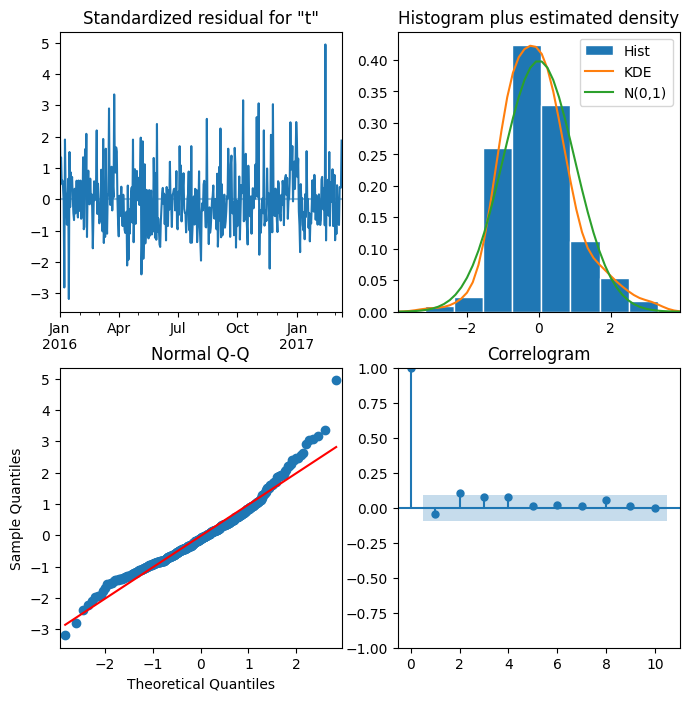

In [ ]:
results.plot_diagnostics(figsize=(8,8));

> **Q. By observing the residual plots, what can we infer about the patterns in the residuals?**

- The residuals have **constant variance**.
- Majority of the dots lie on the red line in the Normal Q-Q plot
 - Hence, the residuals follow a **normal distribution.**
- The residuals are **not auto correlated** as there is no significant pattern.


  

#### Some properties of residuals in time series forecasting
 * The residuals should **not be correlated**
  - Correlated residuals will imply that we are unable to capture some information / pattern in our model.
 * It is useful if the residuals are **normally distributed**
  - It makes calculating the prediction intervals easier.
 * The residuals should have a **zero mean**
  - Otherwise, the forecast can said to be biased.
  - Because a positive mean would mean would imply underfitting and vica-versa

---

## Exogenous Variables

Now let's use the predict() function to get the predictions for the observations in the test data.

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end)

#### Observing the relation of predicted vs actual values on holidays

Let's plot the predicted forecasts and the actual observed values on the test set, and calculate performance scores.

Also, let's add a red line to indicate the **holidays** in the test set.

**Instructor Note:**
> - No need to run the cell as the plot will be same as the attached image but arrows will not be there.

MAE : 25.159
RMSE : 31.97
MAPE: 0.202


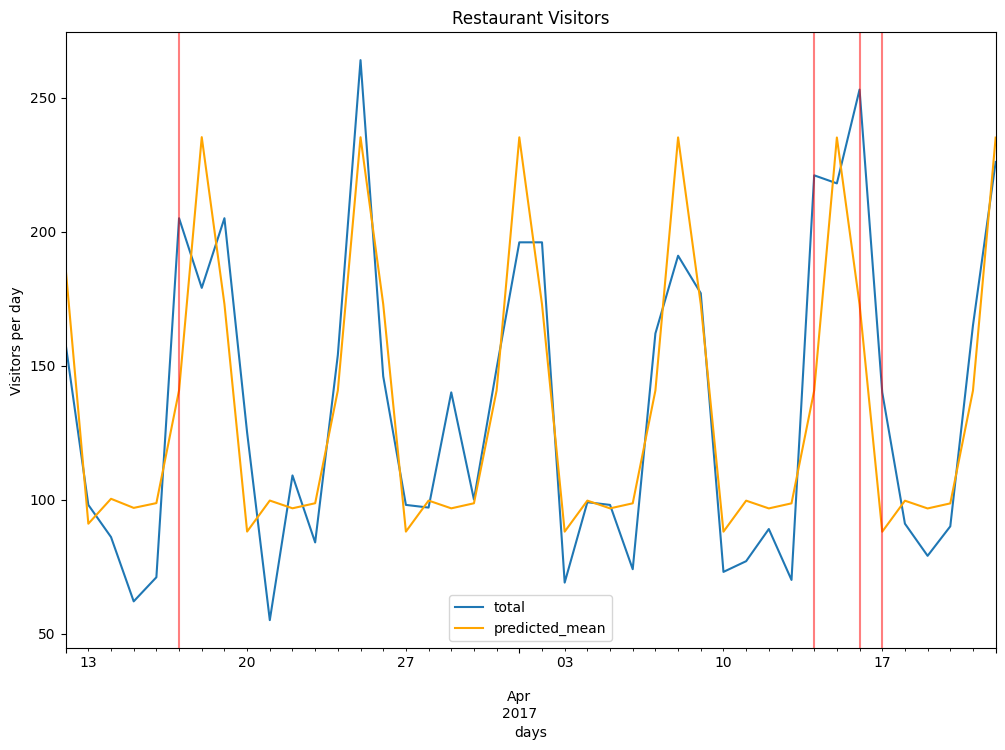

In [ ]:
performance(test['total'], predictions)
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='days'
ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True,color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index:
    ax.axvline(x=x, color='red', alpha = 0.5)

MAE : 25.159<br>
RMSE : 31.97<br>
MAPE: 0.202<br>
<img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/007/768/original/Screenshot_2022-07-22_at_10.41.50_AM.png?1658466294" width="800" height="400">

> **Q. Can you observe any difference between actual and predicted values on the days when there was a holiday?**

 If we look at the plot of total vs predictions, it can be observed that the model has missed peaks for the holidays (see the arrows).

## SARIMAX Model



Now let's fit a SARIMAX model with the exogenous variable 'holiday'.

In [ ]:
model = SARIMAX(train['total'],exog=train['holiday'],order=(1,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()

Let's obtain the forecasts with this SARIMAX model trained with exogenous variable.

In [ ]:
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('Predictions')

#### Let's plot the predicted vs actual forecast values, and observe them closely on holidays.

**Instructor Note:**
> * No need to run the cell as the plot will be the same but arrows will not be there.

MAE : 18.649
RMSE : 22.93
MAPE: 0.161


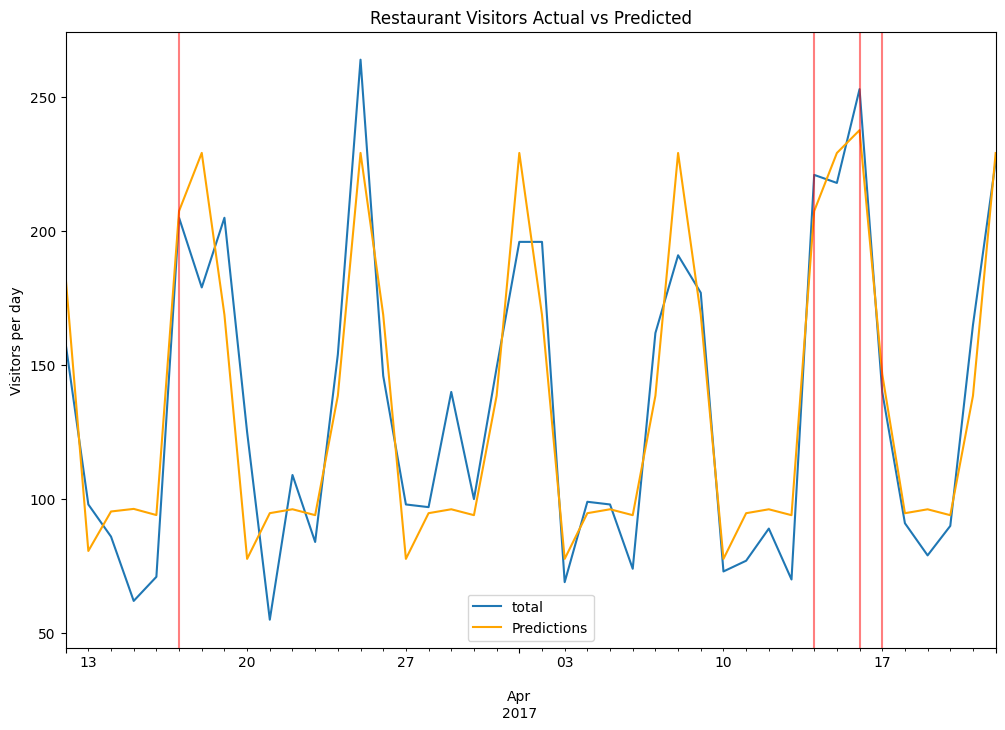

In [ ]:
performance(test['total'], predictions)
# Plot predictions against known values
title='Restaurant Visitors Actual vs Predicted'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True, color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index:
    ax.axvline(x=x, color='red', alpha = 0.5);

MAE : 18.649<br>
RMSE : 22.93<br>
MAPE: 0.161<br>
<img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/007/810/original/Screenshot_2022-07-22_at_9.12.57_PM.png?1658504130" width = 800, height = 400/>

- It can be observed that the predictions now are somewhat more closer to the peaks, for holidays.
 - Observe the arrows.

- Moreover, the peformace has also improved a lot.



####**Forecasting for the 39 newer observations**

We earlier dropped the rows which had Nan in the starting, now let's predict the values of `total` for these 39 observations.

Now we will be using SARIMAX to forecast the number of visitors of the last 39 observations which had null values. We will be using the 'holiday' data.

In [ ]:
model = SARIMAX(df['total'],exog=df['holiday'],order=(1,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df1[478:][['holiday']]
fcast = results.predict(478,df1.shape[0]-1,exog = exog_forecast).rename('Forecast')

In the above code snippet we are using `df1` to get the `holiday` data for the rows where the `total` was none and we dropped them.

Here we are just visualizing the last 100 observations of the dataset, for clear visualization.

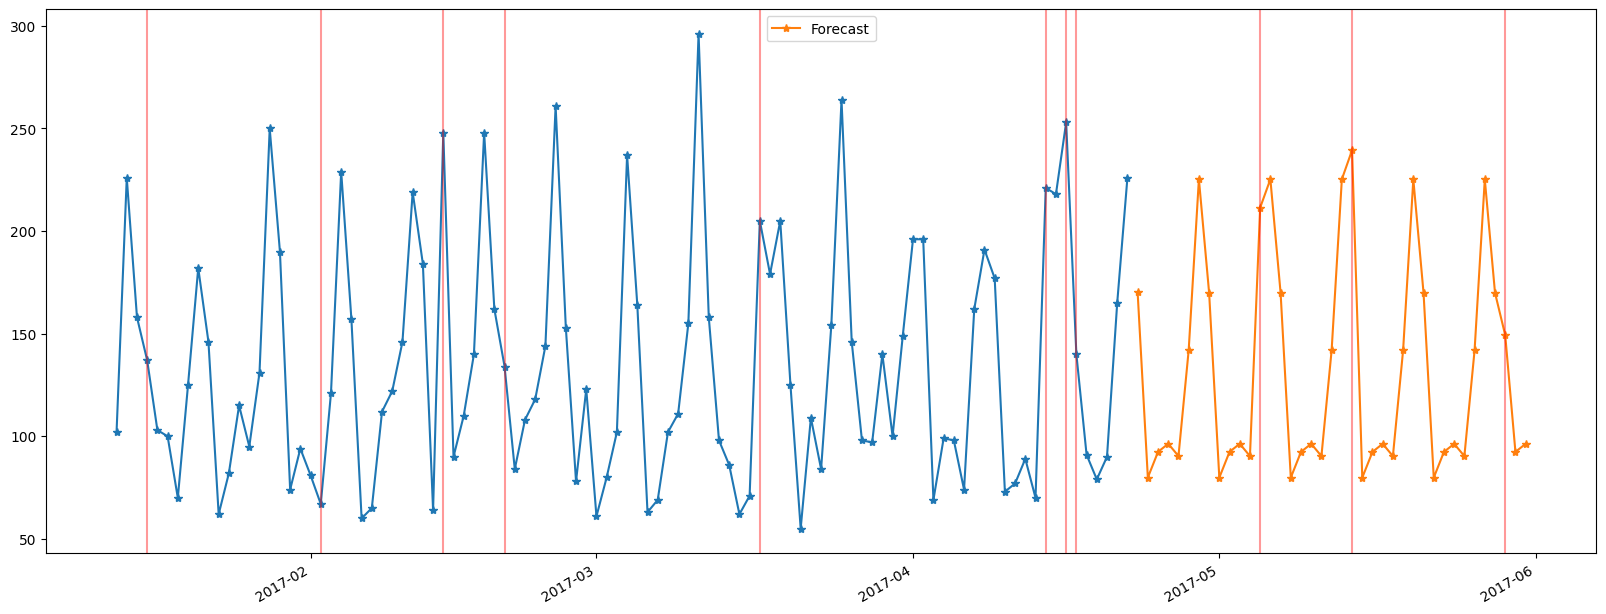

In [ ]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='days'

# ax = df['total'][-100:].plot(legend=True,figsize=(16,5),title=title, style = '-*')
plt.plot(df[-100:].index, df[-100:].total, '-*')
fcast.plot(legend=True, style = '-*')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df[-100:].query('holiday==1').index:
    plt.axvline(x=x, color='red', alpha = 0.4)

for x in df1[-42:].query('holiday==1').date:
    plt.axvline(x=pd.to_datetime(x), color='red', alpha = 0.4)


Note that as a real forecaster,
- you will have to decide wether the future plot looks correct or not.
- Metrics and other measures aside, it is your responsibility that forecast should be correct.
- Hence forecasting is a game of experience, not just theory and code

## Time Series with Linear Regression

> **INSTRUCOTR NOTES**
> - Go slowly through code, print output at each step

### Can we use a regression for a time series problem?

In the ADF test performed earlier we saw that the data is **stationary**

Therefore let's try to forecast the values using linear regression.


In [ ]:
df = df1.copy()
df['date'] = pd.to_datetime(df['date'])

We have seen in the decomposed plots that the number of visitors alter during weekdays and weekends and there is also some pattern in the trends over the weeks.

> **Q. Keeping the above observations in mind can you think of some new variables that we can derive from the existing values and can use for our predictions?**

Earlier we saw that the number of visitors was higher on the weekends according to the data.

Therefore let's try engineering a new feature which indicates whether there is a weekend or not.

In [ ]:
df["weekday"] = np.where(((df["weekday"] == "Friday") | (df["weekday"] == "Thursday") | (df["weekday"] == "Wednesday") | (df["weekday"] == "Tuesday") | (df["weekday"] == "Monday")), "working_day", "weekend")
intmdt = pd.get_dummies(df['weekday'])
df = pd.concat([df, intmdt],axis =1 )
df.head()

,date,weekday,holiday,total,weekend,working_day
0,2016-01-01,working_day,1,296.0,0,1
1,2016-01-02,weekend,0,191.0,1,0
2,2016-01-03,weekend,0,202.0,1,0
3,2016-01-04,working_day,0,105.0,0,1
4,2016-01-05,working_day,0,98.0,0,1


As we have seen the repetition of patterns over the months therefore let's engineer a feature which consist of the average of the last one month's values.

Now let's calculate the values of past 1-31 days number of visitors for each observation storing in columns with name Lag_i where i is the previous ith day's observation.

In [ ]:
for i in range(1,32):
  df["Lag_{}".format(i)] = df['total'].shift(i)

- We could also have used `resample('M')` in combination with `groupby()` in order to get the average of last 31 days.
- But here we are using `Lag` because we also want to have different `Lag` values.
- Computationally it would make sense to use `resample`, but here we are just going to try different combinations of features.

Let's try to use the average of past one months values for each observation as a feature named `average_monthly_lag`

In [ ]:
lis = ['Lag_{}'.format(i) for i in range(1,32)]
df.dropna(inplace = True)    # Drop because some Lags will be NaN.
df['last_month_avg_level'] = df.loc[:,lis].sum(axis=1)/31
df.head()

,date,weekday,holiday,total,weekend,working_day,Lag_1,Lag_2,Lag_3,Lag_4,...,Lag_23,Lag_24,Lag_25,Lag_26,Lag_27,Lag_28,Lag_29,Lag_30,Lag_31,last_month_avg_level
31,2016-02-01,working_day,0,94.0,0,1,204.0,225.0,150.0,95.0,...,234.0,149.0,69.0,83.0,98.0,105.0,202.0,191.0,296.0,143.419355
32,2016-02-02,working_day,1,100.0,0,1,94.0,204.0,225.0,150.0,...,212.0,234.0,149.0,69.0,83.0,98.0,105.0,202.0,191.0,136.903226
33,2016-02-03,working_day,0,72.0,0,1,100.0,94.0,204.0,225.0,...,101.0,212.0,234.0,149.0,69.0,83.0,98.0,105.0,202.0,133.967742
34,2016-02-04,working_day,0,97.0,0,1,72.0,100.0,94.0,204.0,...,57.0,101.0,212.0,234.0,149.0,69.0,83.0,98.0,105.0,129.774194
35,2016-02-05,working_day,0,147.0,0,1,97.0,72.0,100.0,94.0,...,65.0,57.0,101.0,212.0,234.0,149.0,69.0,83.0,98.0,129.516129


Similarly let's use a feature 'average_weekly_lag' for an average past 7 days observations.



In [ ]:
lis = ['Lag_{}'.format(i) for i in range(1,8)]
df['last_week_avg_level'] = df.loc[:,lis].sum(axis=1)/7
df.head(3)

,date,weekday,holiday,total,weekend,working_day,Lag_1,Lag_2,Lag_3,Lag_4,...,Lag_24,Lag_25,Lag_26,Lag_27,Lag_28,Lag_29,Lag_30,Lag_31,last_month_avg_level,last_week_avg_level
31,2016-02-01,working_day,0,94.0,0,1,204.0,225.0,150.0,95.0,...,149.0,69.0,83.0,98.0,105.0,202.0,191.0,296.0,143.419355,135.714286
32,2016-02-02,working_day,1,100.0,0,1,94.0,204.0,225.0,150.0,...,234.0,149.0,69.0,83.0,98.0,105.0,202.0,191.0,136.903226,135.571429
33,2016-02-03,working_day,0,72.0,0,1,100.0,94.0,204.0,225.0,...,212.0,234.0,149.0,69.0,83.0,98.0,105.0,202.0,133.967742,139.000000


We can have 'average_biweekly_lag' as well.

In [ ]:
lis = ["Lag_{}".format(i) for i in range(1,15)]
df['last_2week_avg_level'] = df.loc[:,lis].sum(axis = 1)/14
df.head(3)

,date,weekday,holiday,total,weekend,working_day,Lag_1,Lag_2,Lag_3,Lag_4,...,Lag_25,Lag_26,Lag_27,Lag_28,Lag_29,Lag_30,Lag_31,last_month_avg_level,last_week_avg_level,last_2week_avg_level
31,2016-02-01,working_day,0,94.0,0,1,204.0,225.0,150.0,95.0,...,69.0,83.0,98.0,105.0,202.0,191.0,296.0,143.419355,135.714286,139.214286
32,2016-02-02,working_day,1,100.0,0,1,94.0,204.0,225.0,150.0,...,149.0,69.0,83.0,98.0,105.0,202.0,191.0,136.903226,135.571429,136.500000
33,2016-02-03,working_day,0,72.0,0,1,100.0,94.0,204.0,225.0,...,234.0,149.0,69.0,83.0,98.0,105.0,202.0,133.967742,139.000000,136.500000


**Now lets capture weekly seasonality**

In [ ]:
df['dayofweek'] = df['date'].dt.dayofweek
df['sale_wrt_dow'] = df.groupby('dayofweek')['total'].transform('mean')
df[['sale_wrt_dow', 'dayofweek']].drop_duplicates()

,sale_wrt_dow,dayofweek
31,89.593750,0
32,94.531250,1
33,94.687500,2
34,99.015625,3
35,147.171875,4
36,229.125000,5
37,178.460317,6


In [ ]:
df.shape

(447, 42)

Let's retrieve the present features and columns in the dataframe to decide which featues we can use in predictions.

In [ ]:
df.columns

Index(['date', 'weekday', 'holiday', 'total', 'weekend', 'working_day',
       'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8',
       'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12', 'Lag_13', 'Lag_14', 'Lag_15',
       'Lag_16', 'Lag_17', 'Lag_18', 'Lag_19', 'Lag_20', 'Lag_21', 'Lag_22',
       'Lag_23', 'Lag_24', 'Lag_25', 'Lag_26', 'Lag_27', 'Lag_28', 'Lag_29',
       'Lag_30', 'Lag_31', 'last_month_avg_level', 'last_week_avg_level',
       'last_2week_avg_level', 'dayofweek', 'sale_wrt_dow'],
      dtype='object')

Let's keep a copy of this version of the dataset so that we could use them later.

In [ ]:
import copy             #dfo has the data with all the columns
dfo = df.copy()

Let's try to use a combination of newly engineered variables with Lag_1 and weekend to train the linear regression model.

Drop all the columns which we don't need to use while predicting the number of visitors in the test data.

In [ ]:
df = dfo.copy()
df = df[['total', 'Lag_1', 'last_month_avg_level', 'last_week_avg_level',
          'last_2week_avg_level', 'sale_wrt_dow', 'holiday']]
df.head()

,total,Lag_1,last_month_avg_level,last_week_avg_level,last_2week_avg_level,sale_wrt_dow,holiday
31,94.0,204.0,143.419355,135.714286,139.214286,89.593750,0
32,100.0,94.0,136.903226,135.571429,136.500000,94.531250,1
33,72.0,100.0,133.967742,139.000000,136.500000,94.687500,0
34,97.0,72.0,129.774194,134.285714,134.000000,99.015625,0
35,147.0,97.0,129.516129,134.571429,133.357143,147.171875,0


Splitting the dataset into train and test.Preparing X and y for training the model.

In [ ]:
train = df.iloc[:df.shape[0]-42].dropna()
test = df.iloc[df.shape[0]-42:]


train_X = train.drop(["total"],axis =1)
train_y = train['total']
test_X = test.drop(["total"],axis =1)
test_y = test['total']

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape

# Train and pred
model = LinearRegression()
model.fit(train_X, train_y)
y_pred = pd.Series(model.predict(test_X), index=test.index)
mape(test['total'],y_pred)

0.1550950649148067

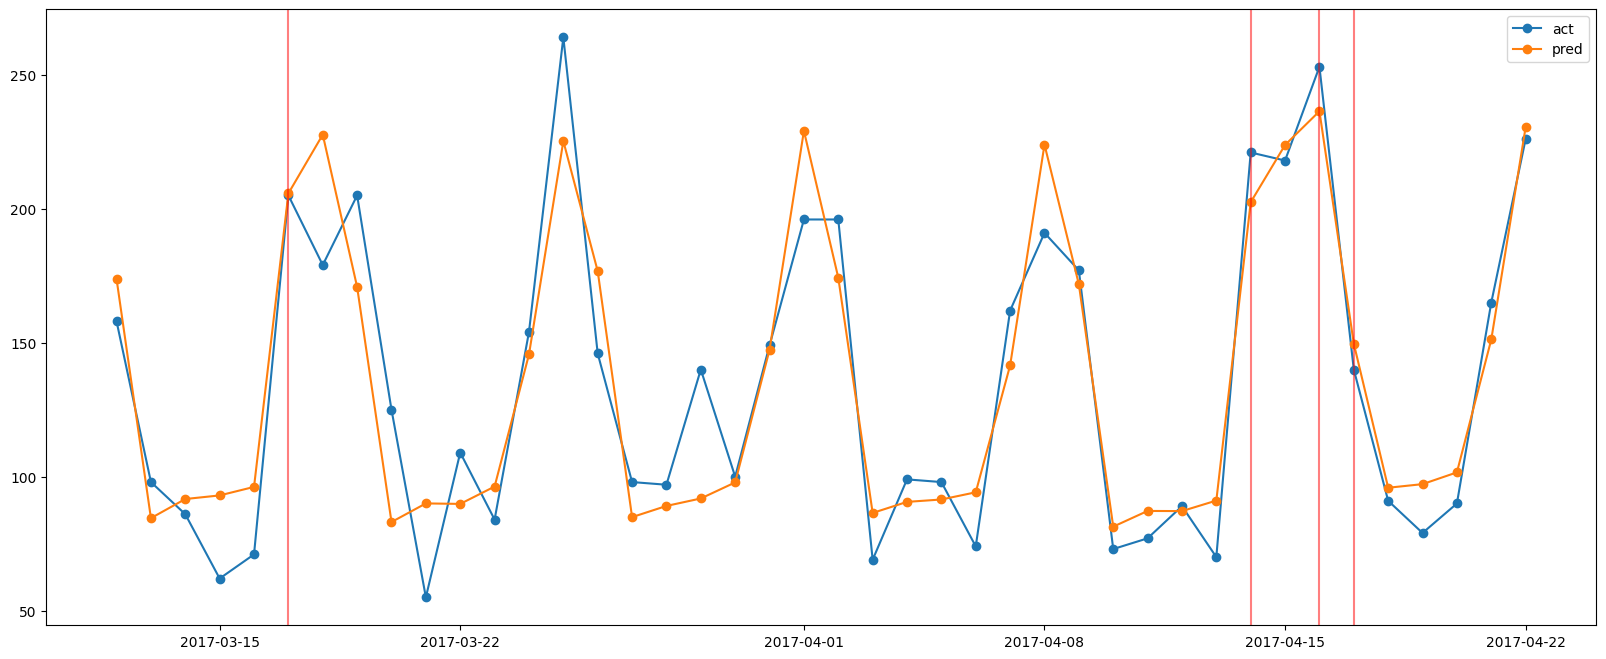

In [ ]:
plt.plot(dfo.tail(42)['date'], test_y, '-o', label='act')
plt.plot(dfo.tail(42)['date'], y_pred, '-o', label='pred')
for x in dfo[-42:].query('holiday==1')['date']:
    plt.axvline(x=x, color='red', alpha = 0.5)
plt.legend()

- This performance is surprisingly very good.
- Note that this is a much simpler algorithm than SARIMAX.

Further improvements can be done with

- Thinking of more inovative features.
- Better feature selection
- Different regressors and Hyper parameter tuning
- Stacking / Cascading etc.

> **IMPORTANT NOTE**
> - please note that SARIMAX forecast was 1 - 42 days into the future. This forecast is only 1 day into the future!! Lag_1 has been used as a feature!
> - For multiple days ahead forecast you need a **new LR for each horizon**. Shift your target by -k, where k is horizon-1

## Introduction to Facebook’s Prophet



### Prophet Implementation

* We're using the same dataset .

* For using Prophet, data set should contain only two columns with column names as ‘ds’ and ‘y’

* ‘ds’ should always be in ‘date-time’ format.

In [ ]:
df = df1.copy()

In [ ]:
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['total']
df = df[['ds', 'y', 'holiday']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ds       517 non-null    datetime64[ns]
 1   y        478 non-null    float64       
 2   holiday  517 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 12.2 KB


#### Fitting Prophet

* `make_future_dataframe` creates a placeholder for storing future variables, so we will be predicting future values for 12 periods.

* Firstly, let's try to fit a model without adding seasonality component and holiday effects.

For using `prophet` we need to install `pystan` which is an interface.

**Instructor Note**:
> - This installation will take around 5-6 mins, so better to do it earlier.

In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 68.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.19.1.1-cp310-cp310-linux_x86_64.whl size=61975964 sha256=5a7b091a5d12a27f0a3165b48b0f63eb79680d7f7133cb625e410fdd66955859
  Stored in directory: /root/.cache/pip/wheels/3d/1c/94/4516243362eedbedad15ac4389691ee3bf2d45bec2639c9d8b
Successfully built pystan
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 84.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 84.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates 

In [ ]:
from fbprophet import Prophet
m = Prophet()
m.fit(df[['ds', 'y']][:-39]) #here we are leaving last 39 observations because we will predict it in 'future'
future = m.make_future_dataframe(periods=39,freq="D")
forecast = m.predict(future)
fig = m.plot(forecast)

ModuleNotFoundError: ignored

* In the plot, black dots are actual visits, deep blue lines are the predicted visits and light blue lines is the 95% confidence interval around the prediction.

- You can see that the lines are flat and the model is not able to capture the seasonality properly so it is not a good fit.
- Here light blue lines are 95% confidence intervals around the predictions.
- Here we also didn't do anything explicitly for `Nan` values it was handled by `prophet`.

Let's see what has the model stored in `forecast` in the above code snippet.


In [ ]:
forecast.tail(4)

There are a lot of added features in the dataframe which include `yhat_lower` and `yhat_upper` for the confidence intervals. `yhat` is the prediction.

Comparing the predictions
- Here we are just plotting the observations and predictions of the dates between `2017-01-01` and `2017-04-22`.

In [ ]:
plt.plot(forecast['ds'], forecast['yhat'],'-*', label = 'Predictions')
plt.plot(df['ds'], df['y'], label = 'Actual')
for x in df.query('holiday==1')['ds']:
    plt.axvline(x=x, color='red', alpha = 0.5);
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2017-04-22'))
plt.legend()

- In the plot we can see that the values predicted are flat therefore it's not able to capture the fluctuations properly.

- Here the model is just predicting according to the seasonality it's not taking anything else into account.

- Here the predicted values can be considered as the average seasonality.
  - i.e. The prediction on sunday would be the average of values on past Sundays.

Here we are leaving last 39 observations while calculating the metrics as we don't have actual values of `visitors` for those days.

In [ ]:
performance(df['y'][:-39],forecast['yhat'][:-39])

Now, this time, let's apply seasonality(yearly and weekly), and add holiday effects in our model and fit it in order to get a better model.

This can be done simply by setting `yearly_seasonality` and `weekly_seasonality` as `True`.

####**Q. How can we add exogenous variable to the prophet model?**

We can use `add_regressor` for adding features to the prophet model.

<br>

There is another interesting parameter here: `changepoint_prior_scale`
- If the trend changes are being ovefit (too much flexibility) or underfit (very less flexibility)
- We can adjust the strength of sparse prior using this parameter.
- Default value: 0.05
- Increasing this will make the trend more flexible.

In [ ]:
model2=Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True,
               changepoint_prior_scale=4)
model2.add_regressor('holiday') #adding holidays data in the model3
model2.fit(df[:-39])
forecast2 = model2.predict(df)
fig = model2.plot(forecast2)

In [ ]:
performance(df['y'][:-39],forecast2['yhat'][:-39])

All the metrics have improved from the last model which wasn't using the `holiday` feature.

* We got a Mean absolute percentage error of 18, which might not seem great, but it really depends on the use case.
- The performance has certainly improved in terms of the above mentioned metrics.

In [ ]:
plt.plot(forecast2['ds'], forecast2['yhat'],'-*', label = 'Predictions')
plt.plot(df['ds'], df['y'], label = 'Actual')
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2017-04-22'))
for x in df.query('holiday==1')['ds']:
    plt.axvline(x=x, color='red', alpha = 0.5);
plt.legend()

* We can see the model with added yearly and weekly seasonality and holidays, has a good fit trying to capture most of the data points and patterns.



This time the model didn't give flat outputs.

Even if we don't have the holiday's data, we can use Prophet for getting the holidays data.

In [ ]:
model3=Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True,
               changepoint_prior_scale=4)
model3.add_country_holidays(country_name='US') #adding holidays data in the model2
model3.fit(df[:-39])
future = m.make_future_dataframe(periods=39,freq="D")
forecast3 = model3.predict(df)
fig = model3.plot(forecast2)

In [ ]:
performance(df['y'][:-39],forecast3['yhat'][:-39])

Here the `MAPE` of predictions has gone down to `18.5`
- This is understandable as the `holiday` data given to us would be more exact or subjective to the region which could be more accountable to the fluctuations, than the general holiday data provided by the model.

#### Changing Trends
* Prophet automatically detects the changepoints and will allow the trend to adapt appropriately.

- Prophet detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change.

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast2)
a = add_changepoints_to_plot(fig.gca(), m, forecast2)

* The vertical lines in this figure indicate where the potential change-points were placed.

* Facebook prophet provides automated methods to forecast.
* The model has easily interpretable parameters that can be changed by the analyst to impose assumptions on the forecast.

> **Q. What makes `Prophet` more usable than the other available methods ?**

- Prophet is a simple library and is great for beginners.
- It works best with time series that have strong seasonal effects.
- Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
- We can add multiple regressors or exogenous variables.
- It forms a very good baseline model because almost no feature engineering is required.
- `Interpretability` is one of the key advantages of Prophet.
- If your timeseries follows some business cycles, you can obtain very decent performance quickly.
- It can also be helpful while detecting changepoints.